In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mping
from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib.pyplot import imread, imshow
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/tmp/ipykernel_229293/1047224361.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
torch. cuda. empty_cache() 

In [6]:
import sys
import os
module_path = '/home/srikanth/Downloads/going_modular/'
sys.path.append(os.path.dirname(module_path))

In [7]:
root_path = r"/home/srikanth/Dataset/Hit-GPRec-merged"
dataset_path = os.listdir(root_path)

In [8]:
!python --version

/bin/bash: line 1: python: command not found


In [9]:
import torch
torch.__version__

'2.0.0+cu118'

In [10]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Create Datasets and DataLoaders

In [12]:
class_labels = []

for item in dataset_path:
    #print(item)
    all_classes = os.listdir(root_path + '/' +item)
    for top_object in all_classes:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object)))
            
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split





In [13]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [14]:
from PIL import Image
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])
        self.label_mapping = label2id

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
      return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
      label = self.df.iloc[idx]['labels']
      return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels


In [15]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_df,
    test_df,
    val_df,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = ImageDataset(train_df)
  test_data = ImageDataset(test_df)
  val_data = ImageDataset(val_df)

  # Get class names
  class_names = list(train_df['labels'].unique())

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      #pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      #pin_memory=True,
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      #pin_memory=True,
  )

  return train_dataloader, test_dataloader, val_dataloader, class_names

In [16]:
# # Let's visualize a image in order to know if data is loaded properly or not

# # Get a batch of images
# image_batch, label_batch = next(iter(train_dataloader))

# # Get a single image from the batch
# image, label = image_batch[0], label_batch[0]

# # View the batch shapes
# print(image.shape, label)

# # Plot image with matplotlib
# plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
# plt.title(class_names[label])
# plt.axis(False);

# MODEL

In [17]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names=df['labels'].unique()

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output


In [18]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


In [19]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [16, 197, 768]       [16, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [16, 197, 768]       [16, 197, 768]       --                   --
│    └─Sequential (layers)                                   [16, 197, 768]       [16, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]       [16, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]       [16, 

In [20]:

# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# Let's build a vision transformer

# Train Model

In [23]:
#For MODEL INPUT
LR=0.0001
EPOCHS=20
# Set the batch size
BATCH_SIZE = 8
img_size=(224, 224) # USER DEFINED 
channels=3
img_shape=(img_size[0], img_size[1], channels)

  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2117 | train_acc: 0.9679 | val_loss: 0.1904 | val_acc: 0.9794


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1955 | train_acc: 0.9748 | val_loss: 0.1904 | val_acc: 0.9756


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1959 | train_acc: 0.9739 | val_loss: 0.1899 | val_acc: 0.9771


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1955 | train_acc: 0.9748 | val_loss: 0.1916 | val_acc: 0.9767


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1955 | train_acc: 0.9743 | val_loss: 0.1883 | val_acc: 0.9779


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1955 | train_acc: 0.9749 | val_loss: 0.1903 | val_acc: 0.9765


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1956 | train_acc: 0.9744 | val_loss: 0.1899 | val_acc: 0.9777


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1956 | train_acc: 0.9739 | val_loss: 0.1887 | val_acc: 0.9792


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.1954 | train_acc: 0.9743 | val_loss: 0.1909 | val_acc: 0.9773


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.1956 | train_acc: 0.9745 | val_loss: 0.1928 | val_acc: 0.9786


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.1957 | train_acc: 0.9746 | val_loss: 0.1903 | val_acc: 0.9786


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1955 | train_acc: 0.9748 | val_loss: 0.1894 | val_acc: 0.9779


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1956 | train_acc: 0.9744 | val_loss: 0.1889 | val_acc: 0.9784


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.1956 | train_acc: 0.9738 | val_loss: 0.1905 | val_acc: 0.9767


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.1958 | train_acc: 0.9743 | val_loss: 0.1888 | val_acc: 0.9773


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.1954 | train_acc: 0.9750 | val_loss: 0.1903 | val_acc: 0.9744


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.1956 | train_acc: 0.9743 | val_loss: 0.1913 | val_acc: 0.9773


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.1955 | train_acc: 0.9745 | val_loss: 0.1911 | val_acc: 0.9739


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.1958 | train_acc: 0.9746 | val_loss: 0.1894 | val_acc: 0.9790


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.1955 | train_acc: 0.9744 | val_loss: 0.1891 | val_acc: 0.9803
Confusion matrix: 
[[ 398    0    8    0]
 [   0  977   32    0]
 [   0   21 2315    9]
 [   0    0   46  946]]
Precision: 0.975889241767353
Recall: 0.9755892255892256
F1 score: 0.9755843274963004


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1951 | train_acc: 0.9745 | val_loss: 0.1949 | val_acc: 0.9756


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1948 | train_acc: 0.9749 | val_loss: 0.1957 | val_acc: 0.9739


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1954 | train_acc: 0.9743 | val_loss: 0.1952 | val_acc: 0.9746


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1953 | train_acc: 0.9742 | val_loss: 0.1957 | val_acc: 0.9771


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1952 | train_acc: 0.9745 | val_loss: 0.1948 | val_acc: 0.9773


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1949 | train_acc: 0.9751 | val_loss: 0.1968 | val_acc: 0.9746


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1950 | train_acc: 0.9745 | val_loss: 0.1965 | val_acc: 0.9748


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1954 | train_acc: 0.9743 | val_loss: 0.1955 | val_acc: 0.9733


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.1948 | train_acc: 0.9749 | val_loss: 0.1962 | val_acc: 0.9756


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.1953 | train_acc: 0.9747 | val_loss: 0.1949 | val_acc: 0.9744


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.1953 | train_acc: 0.9742 | val_loss: 0.1953 | val_acc: 0.9752


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1950 | train_acc: 0.9749 | val_loss: 0.1965 | val_acc: 0.9737


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1952 | train_acc: 0.9746 | val_loss: 0.1941 | val_acc: 0.9737


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.1951 | train_acc: 0.9741 | val_loss: 0.1959 | val_acc: 0.9706


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.1949 | train_acc: 0.9744 | val_loss: 0.1953 | val_acc: 0.9742


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.1953 | train_acc: 0.9735 | val_loss: 0.1939 | val_acc: 0.9744


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.1950 | train_acc: 0.9745 | val_loss: 0.1992 | val_acc: 0.9710


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.1949 | train_acc: 0.9750 | val_loss: 0.1970 | val_acc: 0.9723


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.1951 | train_acc: 0.9751 | val_loss: 0.1970 | val_acc: 0.9761


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.1954 | train_acc: 0.9750 | val_loss: 0.1950 | val_acc: 0.9771
Confusion matrix: 
[[ 399    0    7    0]
 [   0  988   21    0]
 [   1   28 2307    9]
 [   0    1   43  948]]
Precision: 0.9770347748467152
Recall: 0.9768518518518519
F1 score: 0.9768463491252286


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1954 | train_acc: 0.9745 | val_loss: 0.1893 | val_acc: 0.9832


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1953 | train_acc: 0.9739 | val_loss: 0.1912 | val_acc: 0.9800


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1955 | train_acc: 0.9741 | val_loss: 0.1907 | val_acc: 0.9813


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1952 | train_acc: 0.9743 | val_loss: 0.1914 | val_acc: 0.9786


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1954 | train_acc: 0.9738 | val_loss: 0.1895 | val_acc: 0.9815


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1950 | train_acc: 0.9742 | val_loss: 0.1922 | val_acc: 0.9786


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1952 | train_acc: 0.9745 | val_loss: 0.1914 | val_acc: 0.9800


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1955 | train_acc: 0.9746 | val_loss: 0.1898 | val_acc: 0.9796


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.1950 | train_acc: 0.9738 | val_loss: 0.1938 | val_acc: 0.9761


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.1955 | train_acc: 0.9742 | val_loss: 0.1921 | val_acc: 0.9805


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.1953 | train_acc: 0.9737 | val_loss: 0.1921 | val_acc: 0.9798


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1953 | train_acc: 0.9746 | val_loss: 0.1911 | val_acc: 0.9784


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1954 | train_acc: 0.9740 | val_loss: 0.1914 | val_acc: 0.9771


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.1954 | train_acc: 0.9741 | val_loss: 0.1905 | val_acc: 0.9779


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.1952 | train_acc: 0.9749 | val_loss: 0.1909 | val_acc: 0.9765


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.1953 | train_acc: 0.9739 | val_loss: 0.1908 | val_acc: 0.9767


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.1953 | train_acc: 0.9741 | val_loss: 0.1941 | val_acc: 0.9763


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.1950 | train_acc: 0.9748 | val_loss: 0.1930 | val_acc: 0.9784


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.1956 | train_acc: 0.9734 | val_loss: 0.1904 | val_acc: 0.9811


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.1952 | train_acc: 0.9740 | val_loss: 0.1919 | val_acc: 0.9786
Confusion matrix: 
[[ 397    0    9    0]
 [   0  958   50    0]
 [   2   23 2309   12]
 [   0    0   44  948]]
Precision: 0.9709070481308849
Recall: 0.9705387205387206
F1 score: 0.970532129339936


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1956 | train_acc: 0.9743 | val_loss: 0.1944 | val_acc: 0.9707


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1956 | train_acc: 0.9748 | val_loss: 0.1930 | val_acc: 0.9724


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1952 | train_acc: 0.9744 | val_loss: 0.1952 | val_acc: 0.9714


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1954 | train_acc: 0.9742 | val_loss: 0.1938 | val_acc: 0.9726


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1952 | train_acc: 0.9747 | val_loss: 0.1945 | val_acc: 0.9712


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1956 | train_acc: 0.9750 | val_loss: 0.1938 | val_acc: 0.9699


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1955 | train_acc: 0.9745 | val_loss: 0.1942 | val_acc: 0.9745


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1956 | train_acc: 0.9743 | val_loss: 0.1930 | val_acc: 0.9693


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.1953 | train_acc: 0.9750 | val_loss: 0.1949 | val_acc: 0.9739


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.1953 | train_acc: 0.9750 | val_loss: 0.1940 | val_acc: 0.9735


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.1955 | train_acc: 0.9741 | val_loss: 0.1945 | val_acc: 0.9718


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1954 | train_acc: 0.9743 | val_loss: 0.1935 | val_acc: 0.9733


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1953 | train_acc: 0.9746 | val_loss: 0.1961 | val_acc: 0.9689


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.1954 | train_acc: 0.9746 | val_loss: 0.1946 | val_acc: 0.9707


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.1954 | train_acc: 0.9743 | val_loss: 0.1946 | val_acc: 0.9729


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.1953 | train_acc: 0.9749 | val_loss: 0.1938 | val_acc: 0.9726


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.1956 | train_acc: 0.9747 | val_loss: 0.1947 | val_acc: 0.9714


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.1953 | train_acc: 0.9744 | val_loss: 0.1959 | val_acc: 0.9661


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.1954 | train_acc: 0.9739 | val_loss: 0.1950 | val_acc: 0.9733


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.1953 | train_acc: 0.9748 | val_loss: 0.1944 | val_acc: 0.9716
Confusion matrix: 
[[ 397    0    9    0]
 [   0  980   28    0]
 [   0   25 2298   23]
 [   0    0   31  961]]
Precision: 0.9756551328009235
Recall: 0.9755892255892256
F1 score: 0.9755991033388168


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1963 | train_acc: 0.9749 | val_loss: 0.1902 | val_acc: 0.9756


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1961 | train_acc: 0.9742 | val_loss: 0.1896 | val_acc: 0.9756


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1958 | train_acc: 0.9745 | val_loss: 0.1909 | val_acc: 0.9735


  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1962 | train_acc: 0.9740 | val_loss: 0.1910 | val_acc: 0.9769


  0%|          | 0/4753 [00:00<?, ?it/s]

KeyboardInterrupt: 

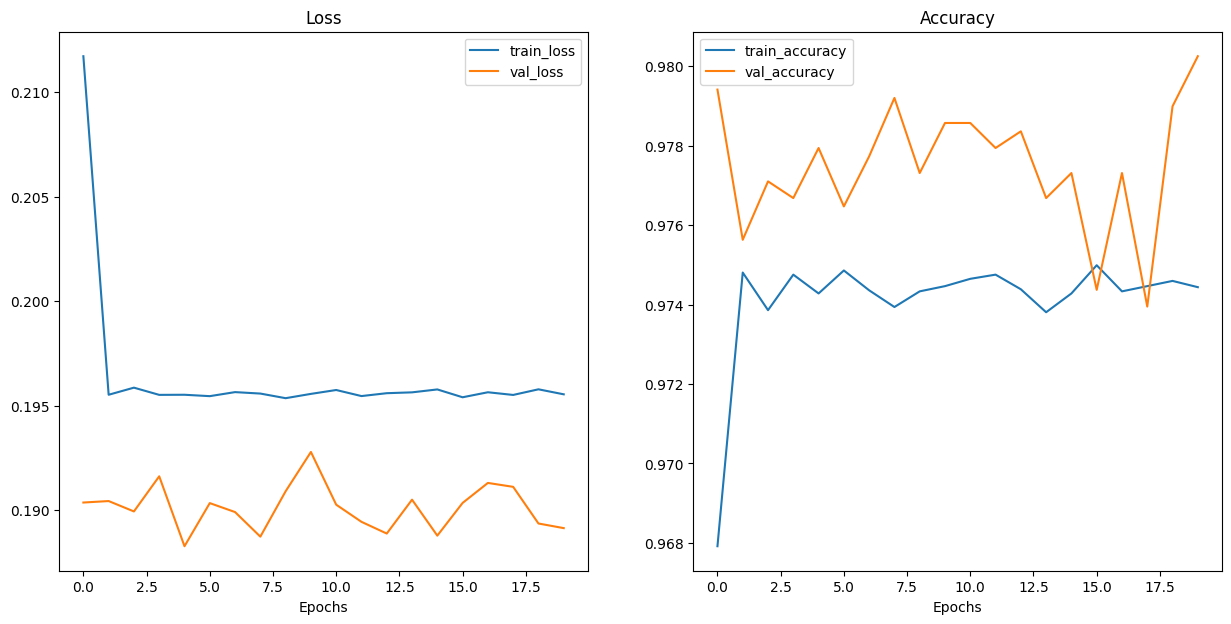

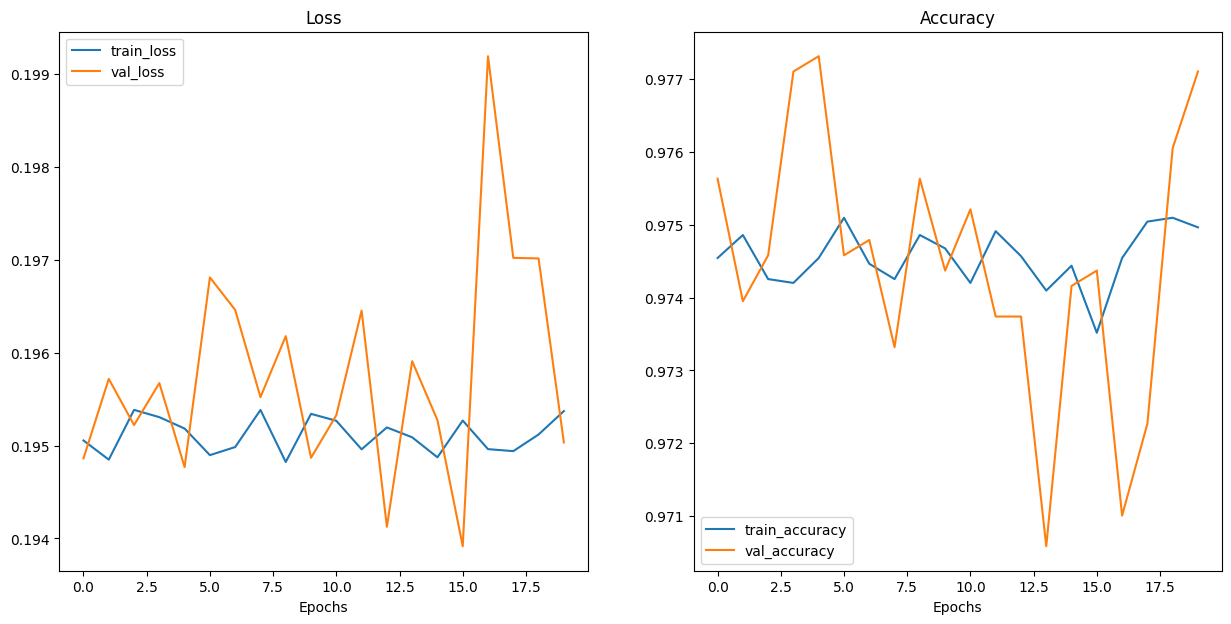

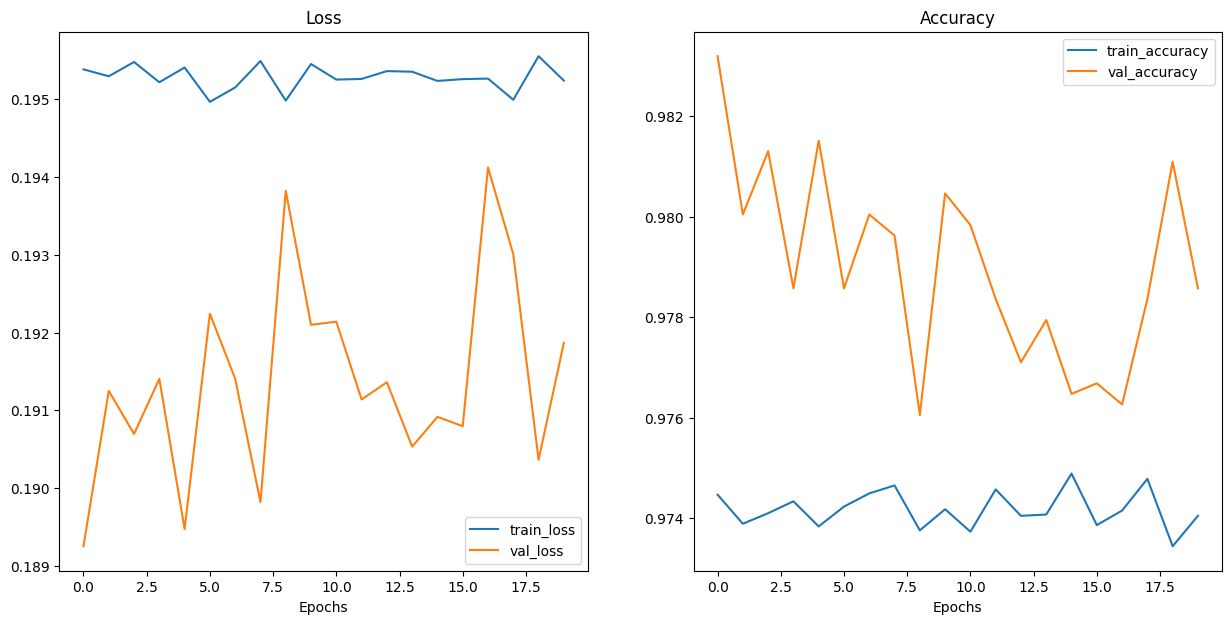

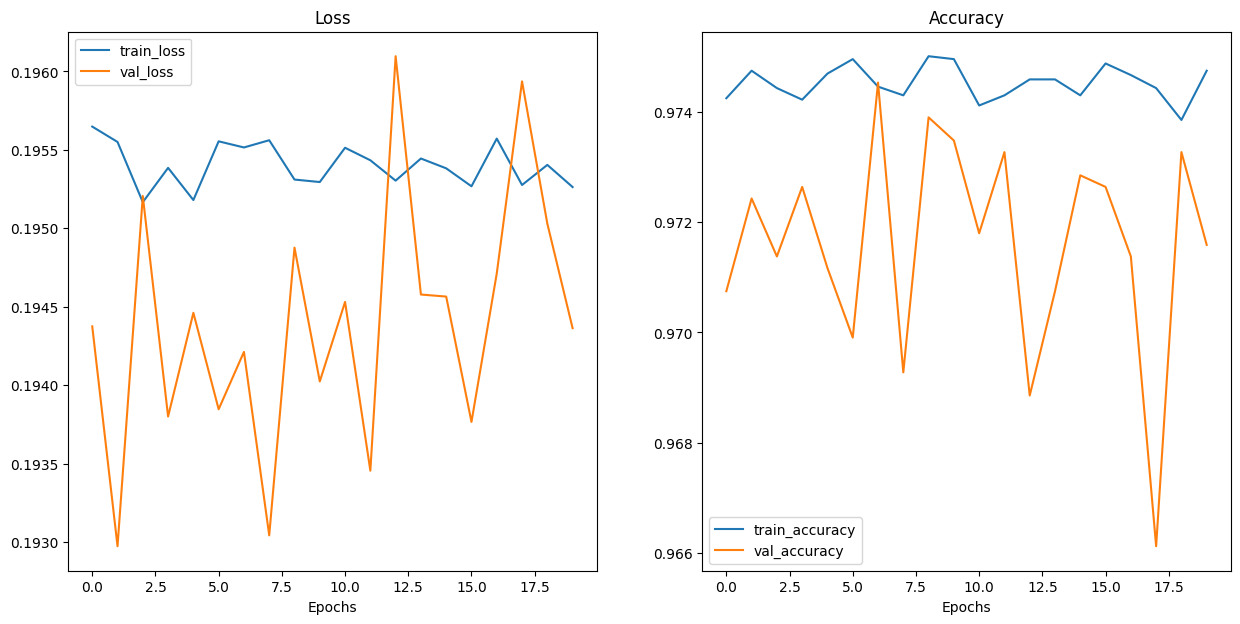

In [24]:
features = [item[1] for item in class_labels]
labels = [item[0] for item in class_labels]
num_folds = 5 
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
kfold.split(features, labels)

average_validation_accuracy = []
for train_indices, test_indices in kfold.split(features, labels):
    train_data = [(labels[i], features[i]) for i in train_indices]
    test_datas = [(labels[i], features[i]) for i in test_indices]
    #print(train_indices)
    num_fold = 2
    test_features = [item[1] for item in test_datas]
    test_labels = [item[0] for item in test_datas]
    kfold_test = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=42)
    for val_indice, test_indice in kfold_test.split(test_features, test_labels):
        val_data = [(test_labels[i], test_features[i]) for i in val_indice]
        test_data = [(test_labels[i], test_features[i]) for i in test_indice]

    # For getting the value address of train image
    new_train_value=[]
    for room in train_data:
        new_train_value.append((room[0],str(room[1])))

    #Creating the Dataframe for Train                
    train_df= pd.DataFrame(data=new_train_value, columns=['labels', 'filepaths'])
            
    # For getting the value address of test image
    new_test_value=[]
    for room in test_data:
        new_test_value.append((room[0],str(room[1])))
            
    #Creating the Dataframe for Testing
    test_df= pd.DataFrame(data=new_test_value, columns=['labels', 'filepaths'])

    # For getting the value address of Validation image
    new_val_value=[]
    for room in val_data:
        new_val_value.append((room[0],str(room[1])))

    #Creating the Dataframe for Validation
    val_df= pd.DataFrame(data=new_val_value, columns=['labels', 'filepaths']) 


#############################################################################################################################################
    

    def scalar(img):    
        return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
    # Create data loaders
    train_gen, test_gen, valid_gen, class_names = create_dataloaders(
        train_df=train_df,
        test_df=test_df,
        val_df=val_df,
        batch_size=BATCH_SIZE
    )

    train_gen, test_gen, valid_gen, class_names
    classes=labels
    class_count=len(classes)
    

#############################################################################################################################################
    import engine

    # Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
    optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                                 lr=LR, # Base LR from Table 3 for ViT-* ImageNet-1k
                                 betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                                 weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

    # Setup the loss function for multi-class classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Set the seeds
    set_seeds()

    # Train the model and save the training results to a dictionary
    pretrained_vit_results = engine.train(model=pretrained_vit,
                           train_dataloader=train_gen,
                           valid_dataloader=valid_gen,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=EPOCHS,
                           device=device)
    average_validation_accuracy.append(pretrained_vit_results["val_acc"])

##############################################################################################################################################
    # To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
    from helper_functions import plot_loss_curves

    # Plot our ViT model's loss curves
    plot_loss_curves(pretrained_vit_results)


#############################################################################################################################################
    # EVALUATION 
    model= pretrained_vit
    model.eval()
    y_true=[]
    y_pred=[]
    for _,(image, label) in enumerate(test_gen):
        y_true.extend(label.cpu().numpy())
        prediction =torch.argmax(torch.softmax(model(image.to(device)),dim=1),dim=1)
        prediction=prediction.cpu().numpy()
        y_pred.extend(prediction)

    
    #confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion matrix: \n{cm}")
    
    #Metrics
    
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")
    


In [ ]:
accuracy=sum(average_validation_accuracy)/5
print(accuracy)

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(pretrained_vit_results)

In [ ]:
torch.save(trained_model.state_dict(), r"/home/srikanth/Downloads/WWC results/vit_model.pt")

# Predictions

In [ ]:
# torch.save(trained_model.state_dict(), r"/home/srikanth/Downloads/results/vit_model.pt")
# import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/home/srikanth/Dataset/RGB_images/Palmar wrist neutral/food_can/food_can_2/food_can_2_1_2_crop.png"

print(pretrained_vit(custom_image_path))
# Predict on custom image
# pred_and_plot_image(model=pretrained_vit,
#                     image_path=custom_image_path,
#                     class_names=class_names)